## 稠密连接网络

### 从ResNet到DenseNet

任意函数的泰勒展开式将这个函数分解成越来越高阶的项，在$x$接近0时，

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$

同样，ResNet将函数展开为

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

因此，ResNet将$f$分解为两部分：一个简单的线性项和一个复杂的非线性项，若想将$f$拓展成超过两部分的信息，一种方案便是DenseNet。

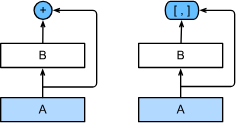

ResNet和DenseNet的关键区别在于，DenseNet输出的是连接（用图中的$[,]$表示）而不是如ResNet的简单相加。

因此，在应用越来越复杂的函数序列后，我们执行从$x$到其展开式的映射：

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

最后，将这些展开式结合到多层感知机中，再次减少特征的数量。实现起来非常简单，不需要添加术语，而是将它们连接起来。

DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密连接。

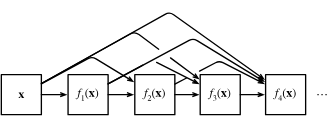

稠密网络主要由2部分构成：稠密块（dense block）和过渡层（transition layer）。前者定义如何连接输入和输出，后者控制通道数量，使其不会太复杂。

### 稠密块体

DenseNet使用了ResNet改良版的“批量规范化、激活和卷积”结构。

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size = 3, padding = 1))

一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出通道。

然而，在前向传播中，我们将每个卷积块的输入和输出在通道维度上连接。

In [8]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
        
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim = 1)
        return X

定义一个有2个输出通道数为10的DenseBlock。使用通道数为3的输入时，会得到通道数为3+2×10=23的输出。卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被成为增长率（growth rate）。

In [9]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### 过渡层

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型，而过渡层可以用来控制模型复杂度。它通过1×1卷积层来间校通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [11]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size = 1),
        nn.AvgPool2d(kernel_size = 2, stride = 2))

对上一个例子中稠密块的输出使用通道数为10的过渡层。此时输出的通道数减为10，高和宽均减半。

In [12]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### DenseNet模型

DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。

In [13]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。
与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。
这里设成4，从而与ResNet-18保持一致。
稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。

In [14]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。

In [15]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

### 训练

training on cpu


KeyboardInterrupt: 

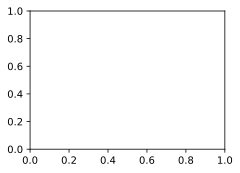

In [16]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())